In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('heart.csv')

df['is_old'] = np.where(df['AGE_50'] >= 55, 1, 0)
df.is_old = df.is_old.astype('category')
df['SES'] = df['SES'].astype('category')
df['CL_STATUS'] = df['CL_STATUS'].astype('category')
df['IHD_DX'] = df['IHD_DX'].astype('category')

y = df['DEATH'] # выбираем целевую переменную (категориальную)
X = df.drop('DEATH', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('AGE_50', axis=1)
df.drop('AGE_50', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   MD_50      200 non-null    int64   
 1   SBP_50     200 non-null    int64   
 2   DBP_50     200 non-null    int64   
 3   HT_50      200 non-null    int64   
 4   WT_50      200 non-null    int64   
 5   CHOL_50    200 non-null    int64   
 6   SES        200 non-null    category
 7   CL_STATUS  200 non-null    category
 8   MD_62      200 non-null    int64   
 9   SBP_62     200 non-null    int64   
 10  DBP_62     200 non-null    int64   
 11  CHOL_62    200 non-null    int64   
 12  WT_62      200 non-null    int64   
 13  IHD_DX     200 non-null    category
 14  DEATH      200 non-null    int64   
 15  is_old     200 non-null    category
dtypes: category(4), int64(12)
memory usage: 20.7 KB


In [58]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

In [59]:
y.value_counts()

DEATH
0    136
1     64
Name: count, dtype: int64

## 1

In [60]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, y], axis=1)

# Разделяем на классы
majority = data[data['DEATH'] == 0]
minority = data[data['DEATH'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('DEATH', axis=1)
y_disbalanced = data_disbalanced['DEATH']

In [61]:
print(y_disbalanced.value_counts())

DEATH
0    136
1     13
Name: count, dtype: int64


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=42)

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

In [63]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9555555555555556

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        42
           1       1.00      0.33      0.50         3

    accuracy                           0.96        45
   macro avg       0.98      0.67      0.74        45
weighted avg       0.96      0.96      0.94        45



В моей ситуации модель переобучилась, но не до состояния полной невозможности предсказать 1.

In [64]:
unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 0, настолько, что не может предсказать 1

{np.int64(0): np.int64(44), np.int64(1): np.int64(1)}

In [65]:
# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=42)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('DEATH', axis=1)
y_balanced = data_balanced['DEATH']


In [66]:
print(y_balanced.value_counts())

DEATH
0    64
1    64
Name: count, dtype: int64


In [67]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [68]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.5384615384615384

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.42      0.47        19
           1       0.54      0.65      0.59        20

    accuracy                           0.54        39
   macro avg       0.54      0.54      0.53        39
weighted avg       0.54      0.54      0.53        39



In [69]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{np.int64(0): np.int64(15), np.int64(1): np.int64(24)}

In [70]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])

In [71]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [72]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.5897435897435898

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.47      0.53        19
           1       0.58      0.70      0.64        20

    accuracy                           0.59        39
   macro avg       0.59      0.59      0.58        39
weighted avg       0.59      0.59      0.58        39



In [73]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{np.int64(0): np.int64(15), np.int64(1): np.int64(24)}

## 2

In [74]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [75]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}

In [76]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.60      0.47      0.53        19
           1       0.58      0.70      0.64        20

    accuracy                           0.59        39
   macro avg       0.59      0.59      0.58        39
weighted avg       0.59      0.59      0.58        39



In [77]:
conf_matrix # Матрица
# TN FP
# FN TP

array([[ 9, 10],
       [ 6, 14]])

In [78]:
rounded_items

{'True Negatives (TN)': np.int64(9),
 'False Positives (FP)': np.int64(10),
 'False Negatives (FN)': np.int64(6),
 'True Positives (TP)': np.int64(14),
 'Accuracy': 0.59,
 'Precision': np.float64(0.58),
 'Recall': np.float64(0.7),
 'F1-score': np.float64(0.64),
 'ROC-AUC': np.float64(0.59)}

## 3

In [79]:
y = df['IHD_DX']

X = df.drop(['IHD_DX', 'DEATH'], axis=1)

In [80]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

In [81]:
X

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,MD_62,SBP_62,DBP_62,...,SES_3,SES_4,SES_5,CL_STATUS_3,CL_STATUS_4,CL_STATUS_5,CL_STATUS_6,CL_STATUS_7,CL_STATUS_8,is_old_1
0,42,1,110,65,64,147,291,4,120,78,...,False,False,False,False,False,False,False,False,True,False
1,53,1,130,72,69,167,278,2,122,68,...,False,False,False,False,False,False,True,False,False,False
2,53,2,120,90,70,222,342,1,132,90,...,False,True,False,False,False,False,False,False,True,False
3,48,4,120,80,72,229,239,2,118,68,...,False,True,False,False,False,False,False,False,True,False
4,53,3,118,74,66,134,243,5,118,56,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,1,115,65,...,False,False,False,False,False,False,False,False,True,False
196,23,1,110,70,69,137,120,2,112,76,...,True,False,False,False,False,False,False,False,True,False
197,20,3,130,80,66,150,210,1,130,85,...,False,False,True,False,False,False,False,False,False,False
198,46,3,140,84,66,138,130,2,148,88,...,False,True,False,False,False,False,True,False,False,False


In [82]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [83]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.58      0.68        43
           1       0.00      0.00      0.00         1
           2       0.18      0.25      0.21         8
           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0
           6       0.25      0.67      0.36         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2

    accuracy                           0.48        60
   macro avg       0.14      0.17      0.14        60
weighted avg       0.61      0.48      0.53        60



C:\Users\sem07\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sem07\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sem07\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [84]:
accuracy_score(y_test_multi, y_pred_multi)

0.48333333333333334

In [85]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi) # ну такое

C:\Users\sem07\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


np.float64(0.1872577519379845)

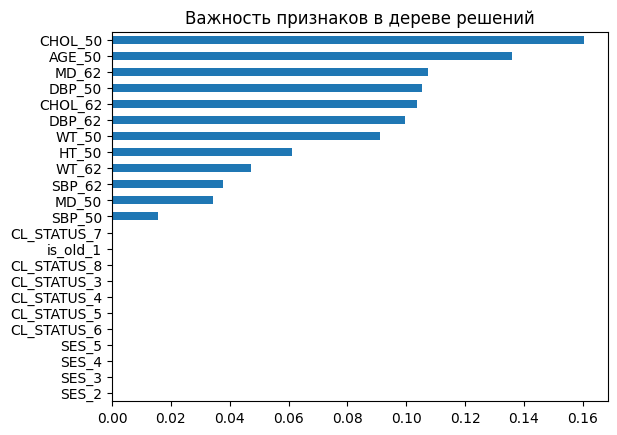

In [86]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

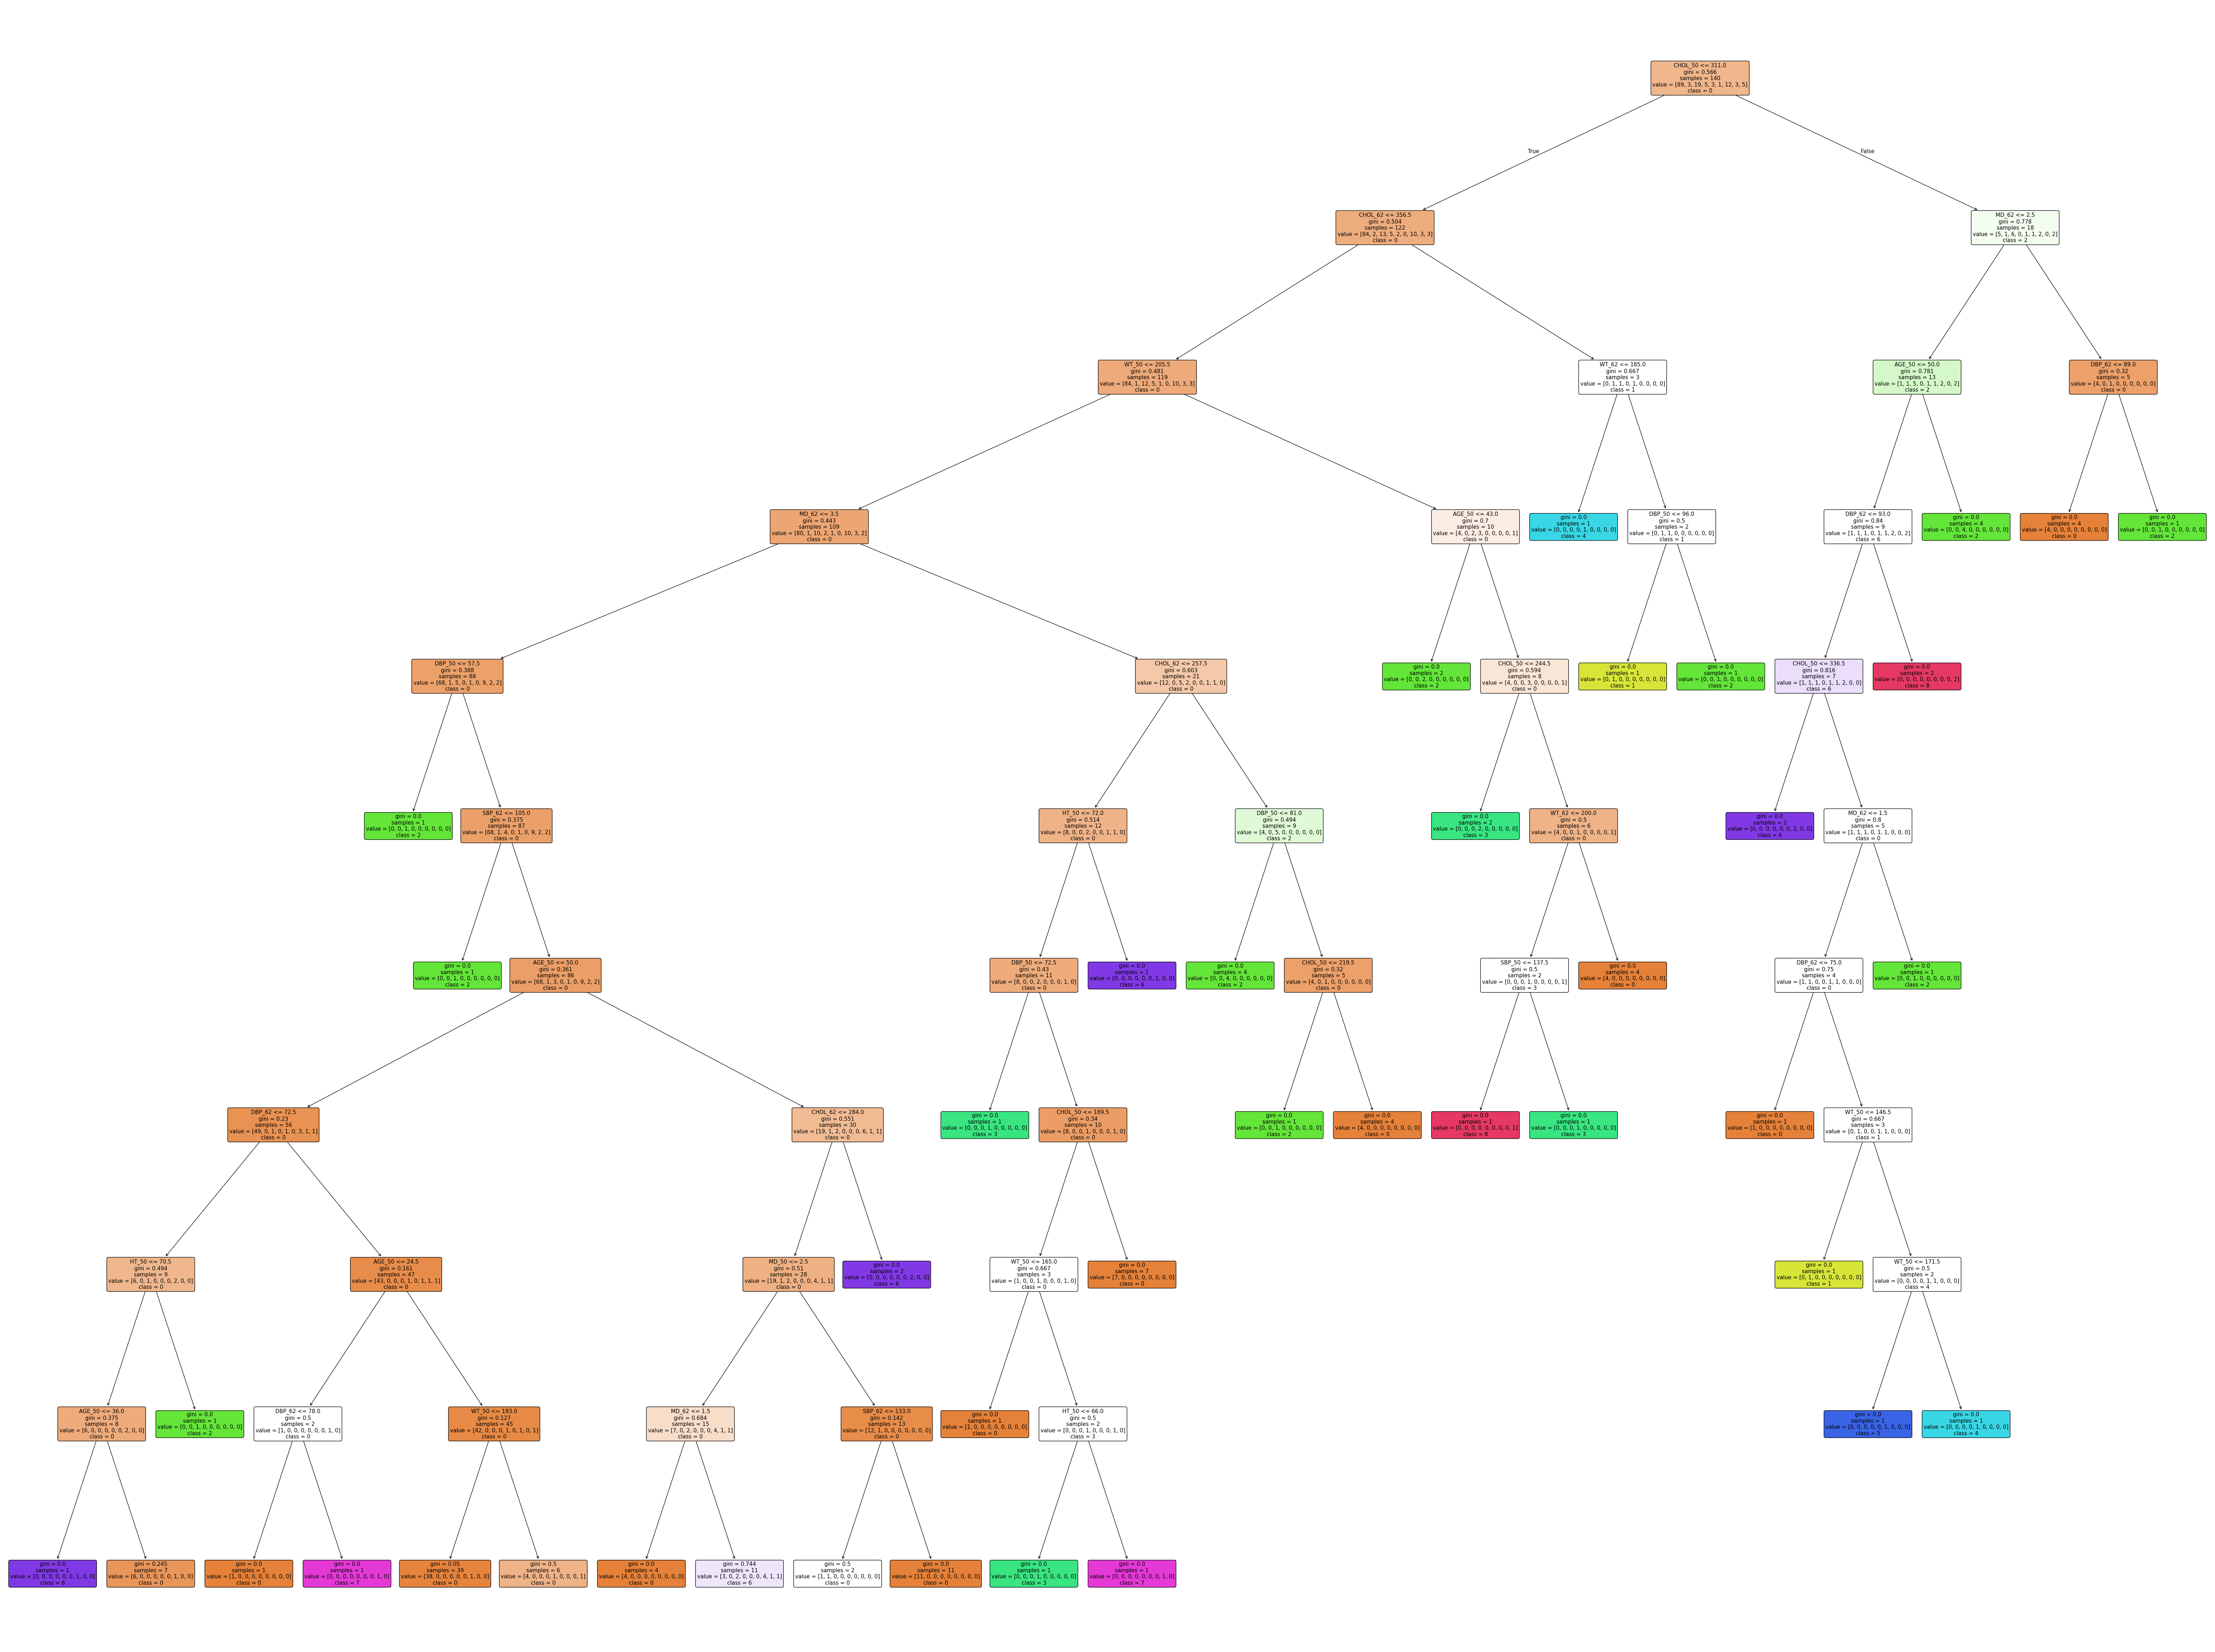

In [87]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()

# ДЗ

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# Загрузка набора данных
df = pd.read_csv('heart.csv')

df['is_old'] = np.where(df['AGE_50'] >= 55, 1, 0)

is_old = np.zeros(len(df['AGE_50']), dtype=np.int16)
for i in range(len(is_old)):
    if df['AGE_50'][i] <= 55:
      is_old[i] = 0
    else:
      is_old[i] = 1

df.is_old = df.is_old.astype('category')
df['SES'] = df['SES'].astype('category')
df['CL_STATUS'] = df['CL_STATUS'].astype('category')
df['IHD_DX'] = df['IHD_DX'].astype('category')

y = df['is_old'] # выбираем целевую переменную (категориальную)
X = df.drop('is_old', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('AGE_50', axis=1)
df.drop('AGE_50', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   MD_50      200 non-null    int64   
 1   SBP_50     200 non-null    int64   
 2   DBP_50     200 non-null    int64   
 3   HT_50      200 non-null    int64   
 4   WT_50      200 non-null    int64   
 5   CHOL_50    200 non-null    int64   
 6   SES        200 non-null    category
 7   CL_STATUS  200 non-null    category
 8   MD_62      200 non-null    int64   
 9   SBP_62     200 non-null    int64   
 10  DBP_62     200 non-null    int64   
 11  CHOL_62    200 non-null    int64   
 12  WT_62      200 non-null    int64   
 13  IHD_DX     200 non-null    category
 14  DEATH      200 non-null    int64   
 15  is_old     200 non-null    category
dtypes: category(4), int64(12)
memory usage: 20.7 KB


In [138]:
X

,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH
0,1,110,65,64,147,291,2,8,4,120,78,271,146,2,1
1,1,130,72,69,167,278,1,6,2,122,68,250,165,9,1
2,2,120,90,70,222,342,4,8,1,132,90,304,223,2,1
3,4,120,80,72,229,239,4,8,2,118,68,209,227,3,1
4,3,118,74,66,134,243,3,8,5,118,56,261,138,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,115,80,66,148,300,2,8,1,115,65,273,152,0,0
196,1,110,70,69,137,120,3,8,2,112,76,198,153,0,0
197,3,130,80,66,150,210,5,0,1,130,85,274,158,0,0
198,3,140,84,66,138,130,4,6,2,148,88,160,157,0,0


In [139]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns, drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.
     

In [141]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = DecisionTreeClassifier(random_state=42, max_depth=5)

sfs = SequentialFeatureSelector(base_model, n_features_to_select=5)
sfs.fit(X, y)

# Получаем список отобранных признаков
selected_features_sfs = X.columns[sfs.get_support()]
print("Отобранные признаки SFS:", selected_features_sfs)

# Отбираем признаки
X_sfs = X[selected_features_sfs]

Отобранные признаки SFS: Index(['WT_62', 'SES_4', 'SES_5', 'CL_STATUS_3', 'CL_STATUS_4'], dtype='object')


In [142]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_sfs, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

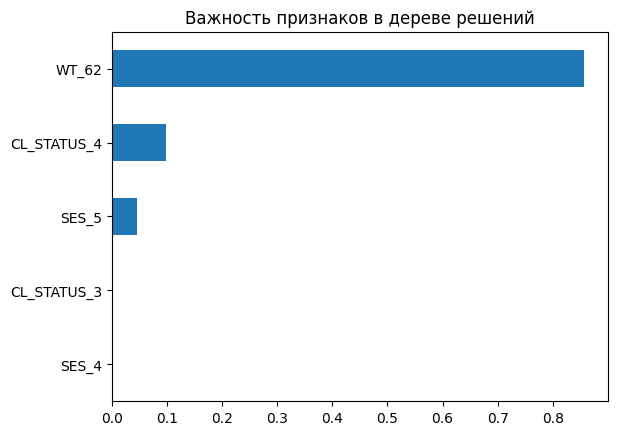

In [143]:
feature_importances = pd.Series(tree_model.feature_importances_, index=X_sfs.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

In [144]:
# Применяем oversampling методом SMOTE
X_over, y_over = SMOTE().fit_resample(X_sfs, y)

y_over.value_counts()

is_old
0    153
1    153
Name: count, dtype: int64

In [145]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

renn = RepeatedEditedNearestNeighbours()

X_under, y_under = renn.fit_resample(X_sfs, y)
y_under.value_counts()

is_old
0    54
1    47
Name: count, dtype: int64

In [146]:
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score
from sklearn.metrics import classification_report

In [147]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = DecisionTreeClassifier(random_state=42, max_depth=5)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

In [148]:
# Без балансировки:
k_fold_cross_validation(X = X_sfs.to_numpy(), y = y.to_numpy())


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85        48
           1       0.75      0.16      0.26        19

    accuracy                           0.75        67
   macro avg       0.75      0.57      0.55        67
weighted avg       0.75      0.75      0.68        67


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89        54
           1       0.56      0.38      0.45        13

    accuracy                           0.82        67
   macro avg       0.71      0.66      0.67        67
weighted avg       0.80      0.82      0.81        67


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.88        51
           1       0.60      0.20      0.30        15

    accuracy                           0.79        66
   macro avg       0.70      0.58      0.59        66

In [149]:
# Oversampling:
k_fold_cross_validation(X = X_over.to_numpy(), y = y_over.to_numpy())


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.91      0.70        54
           1       0.69      0.23      0.34        48

    accuracy                           0.59       102
   macro avg       0.63      0.57      0.52       102
weighted avg       0.63      0.59      0.53       102


Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.58      0.57        48
           1       0.61      0.57      0.59        54

    accuracy                           0.58       102
   macro avg       0.58      0.58      0.58       102
weighted avg       0.58      0.58      0.58       102


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.76      0.65        51
           1       0.64      0.41      0.50        51

    accuracy                           0.59       102
   macro avg       0.60      0.59      0.57       102

In [150]:
# Undersampling:
k_fold_cross_validation(X = X_under.to_numpy(), y = y_under.to_numpy())


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.92      0.73      0.81        15

    accuracy                           0.85        34
   macro avg       0.87      0.84      0.85        34
weighted avg       0.86      0.85      0.85        34


Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        22
           1       1.00      0.58      0.74        12

    accuracy                           0.85        34
   macro avg       0.91      0.79      0.82        34
weighted avg       0.88      0.85      0.84        34


Classification Report:
               precision    recall  f1-score   support

           0       0.68      1.00      0.81        13
           1       1.00      0.70      0.82        20

    accuracy                           0.82        33
   macro avg       0.84      0.85      0.82        33

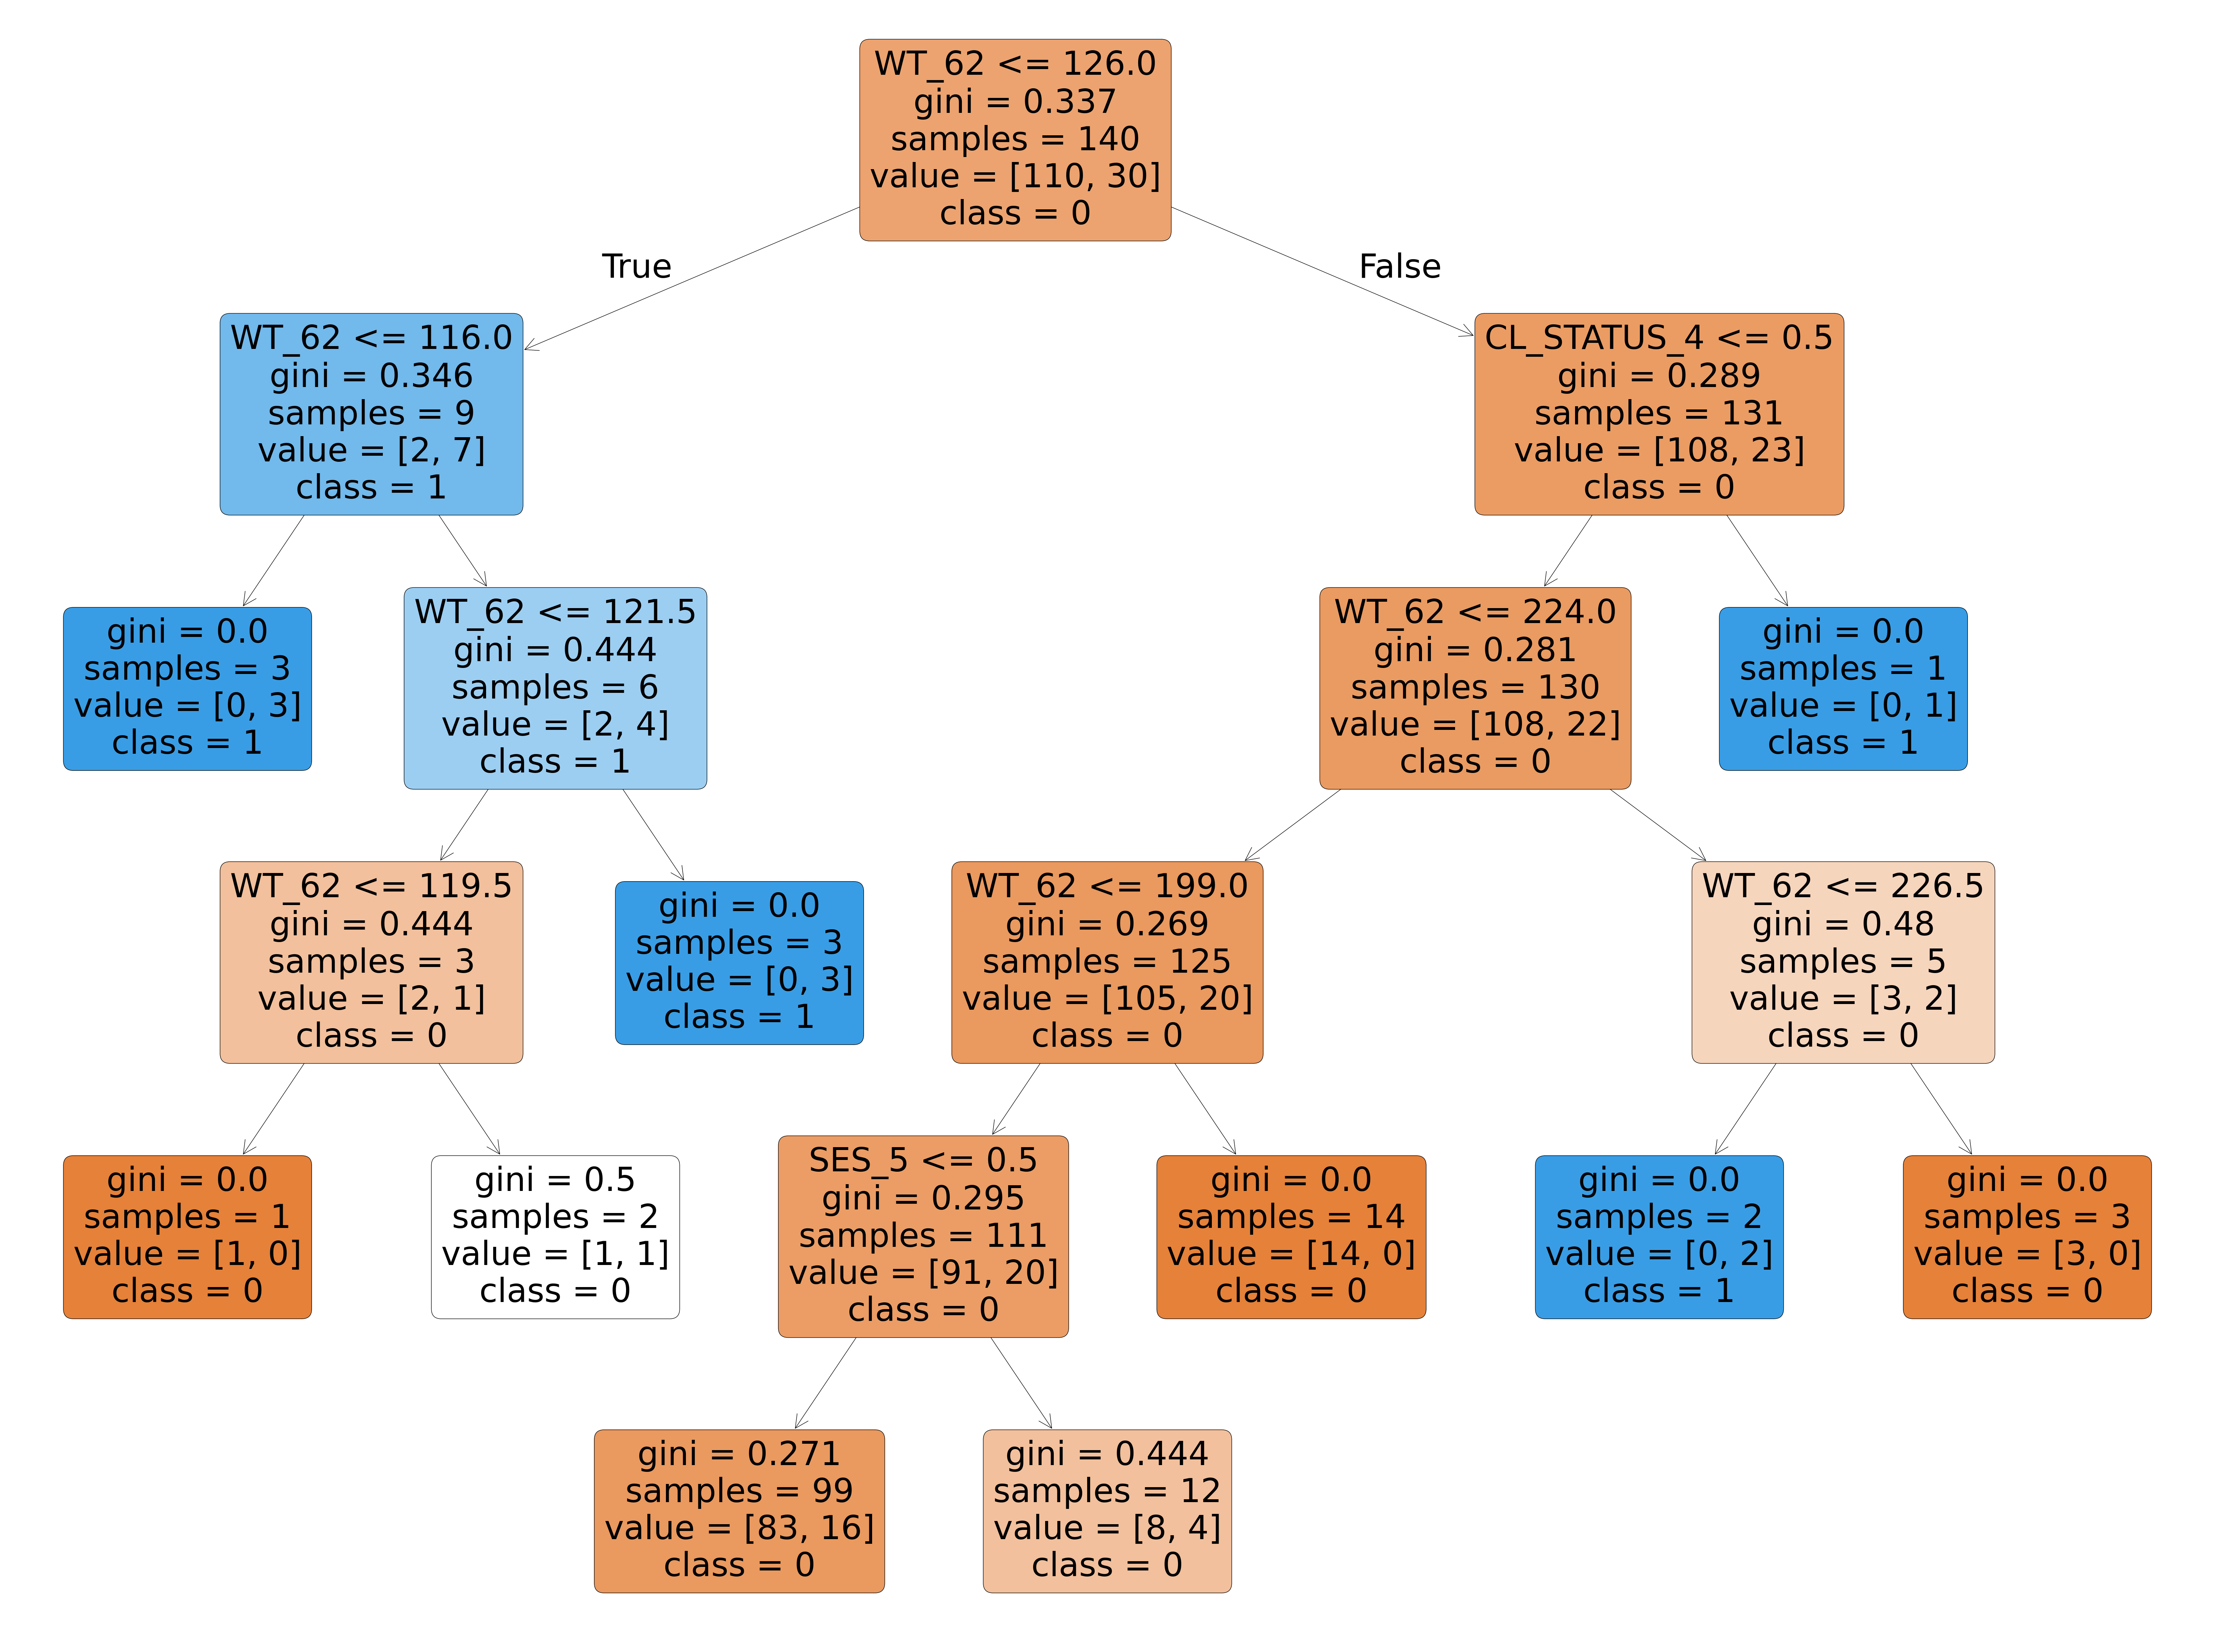

In [151]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X_sfs.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()